In [1]:
import pandas as pd
import numpy as np

In [2]:
import math
import os
from datetime import datetime,timedelta
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset

In [52]:
data = pd.read_csv("../data/processed/period/gfsen/6_16/gfsenperiod1.csv.gz",compression='gzip',parse_dates=["Trade_Datetime","gfsen_pulicate_time"],index_col=["Trade_Datetime"])

In [38]:
weather_data = pd.read_csv("../data/processed/WeatherData/gfsen_weather_subclass.csv", parse_dates=["Trans_INIT_Time"])

In [39]:
weather_data

,Trans_INIT_Time,VALUE_hdd,10Y_NORMAL_hdd,Sum_Value_hdd,Delta_Full_hdd,Delta_Sub_hdd,VALUE_cdd,10Y_NORMAL_cdd,Sum_Value_cdd,Delta_Full_cdd,Delta_Sub_cdd
0,2015-01-01 00:28:00,34.39,28.51,500.45,0.00,0.00,0.24,0.19,3.70,0.00,0.00
1,2015-01-01 06:28:00,34.19,28.51,493.01,-7.44,-3.42,0.24,0.19,3.50,-0.20,-0.11
2,2015-01-01 12:28:00,31.12,28.67,490.88,2.09,0.32,0.42,0.17,3.49,0.10,0.13
3,2015-01-01 18:29:00,31.31,28.67,502.42,11.54,13.98,0.42,0.17,3.43,-0.06,-0.12
4,2015-01-02 00:28:00,31.01,28.67,508.42,6.00,6.12,0.40,0.17,3.05,-0.38,-0.33
...,...,...,...,...,...,...,...,...,...,...,...
9123,2021-03-30 19:29:00,16.56,15.32,188.50,2.34,1.43,0.98,1.01,12.20,-0.60,-0.25
9124,2021-03-31 01:28:00,16.18,15.32,187.04,-1.46,-1.40,1.00,1.01,12.19,-0.01,-0.18
9125,2021-03-31 07:28:00,16.13,15.32,187.57,0.53,3.62,0.96,1.01,12.81,0.62,-0.06
9126,2021-03-31 13:28:00,20.84,15.06,182.02,-0.96,-1.31,0.39,1.02,12.61,-0.77,-0.42


In [41]:
data.head()

,Contract_Delivery_Date,Vwap,gfsen_pulicate_time,dst_flag,Normal_Vwap
Trade_Datetime,,,,,
2015-01-29 06:01:00,1503,2.882,2015-01-29 06:28:00,0,1.000
2015-01-29 06:02:00,1503,2.886,2015-01-29 06:28:00,0,1.001
2015-01-29 06:03:00,1503,2.886,2015-01-29 06:28:00,0,1.001
2015-01-29 06:04:00,1503,2.886,2015-01-29 06:28:00,0,1.001
2015-01-29 06:05:00,1503,2.887,2015-01-29 06:28:00,0,1.002


In [53]:
data["Trade_time"] = data.index.time

In [54]:
res = data.groupby(['Contract_Delivery_Date', pd.Grouper(freq='D')]).agg(Normal_Vwap=('Normal_Vwap', list),Trade_time=('Trade_time',list) ,gfsen_public_time=('gfsen_pulicate_time', 'first'),dst_flag=('dst_flag', 'first'))

In [55]:
merge_data = pd.merge(res, weather_data, how="inner",left_on='gfsen_public_time', right_on='Trans_INIT_Time',
                      suffixes=('_hdd', '_cdd'))
merge_data

,Normal_Vwap,Trade_time,gfsen_public_time,dst_flag,Trans_INIT_Time,VALUE_hdd,10Y_NORMAL_hdd,Sum_Value_hdd,Delta_Full_hdd,Delta_Sub_hdd,VALUE_cdd,10Y_NORMAL_cdd,Sum_Value_cdd,Delta_Full_cdd,Delta_Sub_cdd
0,"[1.0, 1.001, 1.001, 1.001, 1.002, 1.001, 1.001...","[06:01:00, 06:02:00, 06:03:00, 06:04:00, 06:05...",2015-01-29 06:28:00,0,2015-01-29 06:28:00,27.39,29.74,488.93,-6.14,0.38,0.01,0.22,0.55,0.01,-0.09
1,"[1.0, 1.0, 0.998, 0.996, 0.997, 0.996, 0.997, ...","[06:01:00, 06:02:00, 06:03:00, 06:04:00, 06:05...",2015-01-30 06:28:00,0,2015-01-30 06:28:00,31.93,29.67,492.87,-3.61,-4.04,0.03,0.23,0.89,0.15,0.16
2,"[1.0, 1.005, 1.006, 1.003, 1.003, 1.001, 1.001...","[06:01:00, 06:02:00, 06:03:00, 06:04:00, 06:05...",2015-02-02 06:28:00,0,2015-02-02 06:28:00,35.15,29.48,450.13,11.55,11.27,0.11,0.26,0.37,-0.18,-0.12
3,"[1.0, 0.999, 0.999, 0.999, 1.0, 1.001, 1.0, 1....","[06:01:00, 06:02:00, 06:03:00, 06:04:00, 06:05...",2015-02-03 06:28:00,0,2015-02-03 06:28:00,34.48,29.32,471.91,18.91,18.42,0.03,0.27,0.31,-0.24,-0.17
4,"[1.0, 0.999, 0.998, 0.998, 0.997, 0.997, 0.997...","[06:01:00, 06:02:00, 06:03:00, 06:04:00, 06:05...",2015-02-04 06:28:00,0,2015-02-04 06:28:00,31.37,29.19,470.61,-2.54,-4.60,0.10,0.29,0.50,0.09,0.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.001, 1.002, 1.003,...","[06:01:00, 06:02:00, 06:03:00, 06:04:00, 06:05...",2021-03-25 01:28:00,1,2021-03-25 01:28:00,12.87,16.79,197.43,-2.18,-0.70,1.03,0.84,13.68,1.01,0.84
1563,"[1.0, 1.001, 1.002, 1.0, 1.001, 1.001, 1.0, 1....","[06:01:00, 06:02:00, 06:03:00, 06:04:00, 06:05...",2021-03-26 01:28:00,1,2021-03-26 01:28:00,12.54,16.58,200.10,0.56,3.08,1.35,0.88,13.21,-0.07,-0.08
1564,"[1.0, 1.0, 1.0, 0.999, 0.999, 1.001, 1.001, 1....","[06:05:00, 06:06:00, 06:07:00, 06:08:00, 06:09...",2021-03-29 01:28:00,1,2021-03-29 01:28:00,15.53,15.82,189.71,-2.08,0.15,0.68,0.97,13.20,-0.54,-0.35
1565,"[1.0, 1.002, 1.004, 1.003, 1.003, 1.002, 1.002...","[06:01:00, 06:02:00, 06:03:00, 06:04:00, 06:05...",2021-03-30 01:28:00,1,2021-03-30 01:28:00,13.59,15.52,192.67,6.83,4.29,1.05,0.98,13.37,-1.09,-0.93


In [56]:
def dba_fit_predict_data(n_cluster, period_data, data_name, save_model_path=None):
    seed = 13
    dba_km = TimeSeriesKMeans(n_clusters=n_cluster,
                              metric="dtw",
                              n_jobs=8,
                              max_iter_barycenter=10,
                              verbose=False,
                              n_init=2,
                              random_state=seed)
    y_pred = dba_km.fit_predict(period_data)
    if save_model_path:
        file_name = "dba_"+data_name+"_"+str(n_cluster)
        dba_km.to_pickle(os.path.join(save_model_path, file_name+".pkl"))
    return y_pred

In [57]:
period_data = to_time_series_dataset(res["Normal_Vwap"].values)

In [58]:
y_pred = dba_fit_predict_data(n_cluster=16,
                              period_data=period_data,
                              data_name="gfsenperiod1")

In [59]:
merge_data["label"] = y_pred

In [66]:
merge_data

,Normal_Vwap,Trade_time,gfsen_public_time,dst_flag,Trans_INIT_Time,VALUE_hdd,10Y_NORMAL_hdd,Sum_Value_hdd,Delta_Full_hdd,Delta_Sub_hdd,VALUE_cdd,10Y_NORMAL_cdd,Sum_Value_cdd,Delta_Full_cdd,Delta_Sub_cdd,label
0,"[1.0, 1.001, 1.001, 1.001, 1.002, 1.001, 1.001...","[06:01:00, 06:02:00, 06:03:00, 06:04:00, 06:05...",2015-01-29 06:28:00,0,2015-01-29 06:28:00,27.39,29.74,488.93,-6.14,0.38,0.01,0.22,0.55,0.01,-0.09,15
1,"[1.0, 1.0, 0.998, 0.996, 0.997, 0.996, 0.997, ...","[06:01:00, 06:02:00, 06:03:00, 06:04:00, 06:05...",2015-01-30 06:28:00,0,2015-01-30 06:28:00,31.93,29.67,492.87,-3.61,-4.04,0.03,0.23,0.89,0.15,0.16,3
2,"[1.0, 1.005, 1.006, 1.003, 1.003, 1.001, 1.001...","[06:01:00, 06:02:00, 06:03:00, 06:04:00, 06:05...",2015-02-02 06:28:00,0,2015-02-02 06:28:00,35.15,29.48,450.13,11.55,11.27,0.11,0.26,0.37,-0.18,-0.12,7
3,"[1.0, 0.999, 0.999, 0.999, 1.0, 1.001, 1.0, 1....","[06:01:00, 06:02:00, 06:03:00, 06:04:00, 06:05...",2015-02-03 06:28:00,0,2015-02-03 06:28:00,34.48,29.32,471.91,18.91,18.42,0.03,0.27,0.31,-0.24,-0.17,15
4,"[1.0, 0.999, 0.998, 0.998, 0.997, 0.997, 0.997...","[06:01:00, 06:02:00, 06:03:00, 06:04:00, 06:05...",2015-02-04 06:28:00,0,2015-02-04 06:28:00,31.37,29.19,470.61,-2.54,-4.60,0.10,0.29,0.50,0.09,0.08,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.001, 1.002, 1.003,...","[06:01:00, 06:02:00, 06:03:00, 06:04:00, 06:05...",2021-03-25 01:28:00,1,2021-03-25 01:28:00,12.87,16.79,197.43,-2.18,-0.70,1.03,0.84,13.68,1.01,0.84,4
1563,"[1.0, 1.001, 1.002, 1.0, 1.001, 1.001, 1.0, 1....","[06:01:00, 06:02:00, 06:03:00, 06:04:00, 06:05...",2021-03-26 01:28:00,1,2021-03-26 01:28:00,12.54,16.58,200.10,0.56,3.08,1.35,0.88,13.21,-0.07,-0.08,10
1564,"[1.0, 1.0, 1.0, 0.999, 0.999, 1.001, 1.001, 1....","[06:05:00, 06:06:00, 06:07:00, 06:08:00, 06:09...",2021-03-29 01:28:00,1,2021-03-29 01:28:00,15.53,15.82,189.71,-2.08,0.15,0.68,0.97,13.20,-0.54,-0.35,7
1565,"[1.0, 1.002, 1.004, 1.003, 1.003, 1.002, 1.002...","[06:01:00, 06:02:00, 06:03:00, 06:04:00, 06:05...",2021-03-30 01:28:00,1,2021-03-30 01:28:00,13.59,15.52,192.67,6.83,4.29,1.05,0.98,13.37,-1.09,-0.93,7


In [61]:
Normal_Vwap, Trade_time, dst_flag = merge_data[merge_data["label"]==3][["Normal_Vwap","Trade_time", "dst_flag"]].values[2]

In [62]:
Trade_time = [item.strftime('%H:%M:%S') for item in Trade_time]

In [63]:
def show_time_series(period_df, label, axs_fig):
    for Normal_Vwap, Trade_time, dst_flag in period_df[period_df["label"] == label][["Normal_Vwap", "Trade_time", "dst_flag"]].values:
        color = [0.7, 0.8, 0.8]
        if dst_flag == 1:
            color = [1, 0.96, 0.56]
        Trade_time = [item.strftime('%H:%M:%S') for item in Trade_time]
        sns.lineplot(x=Trade_time, y=Normal_Vwap, color=color, ax=axs_fig)

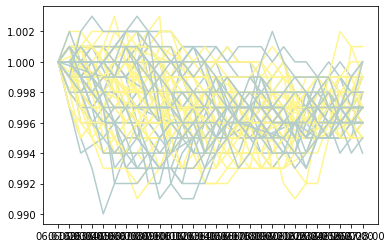

In [65]:
for Normal_Vwap, Trade_time, dst_flag in merge_data[merge_data["label"]==3][["Normal_Vwap","Trade_time", "dst_flag"]].values:
    color = [0.7, 0.8, 0.8]
    if dst_flag == 1:
        color = [1, 0.96, 0.56]
    Trade_time = [item.strftime('%H:%M:%S') for item in Trade_time]
    sns.lineplot(x=Trade_time, y=Normal_Vwap, color=color)

In [22]:
def show_clustering(n_clusters, y_pred, period_df, file_name):
    plot_count = math.ceil(math.sqrt(n_clusters))
    fig, axs = plt.subplots(plot_count, plot_count, figsize=(20, 20))
    row_i = 0
    column_j = 0

    # len_max_index, max_index = get_max_index(period_df)
    for label in set(y_pred):
        show_time_series(period_df=period_df,label=label, axs_fig=axs[row_i, column_j])

        # assert len_max_index == len(dba_km.cluster_centers_[
        #                             label].ravel()), "time max index length error!"
        # show_cluster_center(max_index, dba_km,label=label,axs_fig=axs[row_i, column_j])
        # show_ci_box(ci_df,label=label,ax_fig=axs[row_i, column_j])

        axs[row_i, column_j].set_title(
            "Cluster "+str(row_i*plot_count+column_j))
        axs[row_i, column_j].xaxis.set_major_formatter(
            matplotlib.dates.DateFormatter("%H:%M")
        )
        column_j += 1
        if column_j % plot_count == 0:
            row_i += 1
            column_j = 0
    fig.tight_layout(pad=1.0)
    # plt.savefig(file_name+".png", dpi=200,
    #             bbox_inches="tight", orientation='landscape')

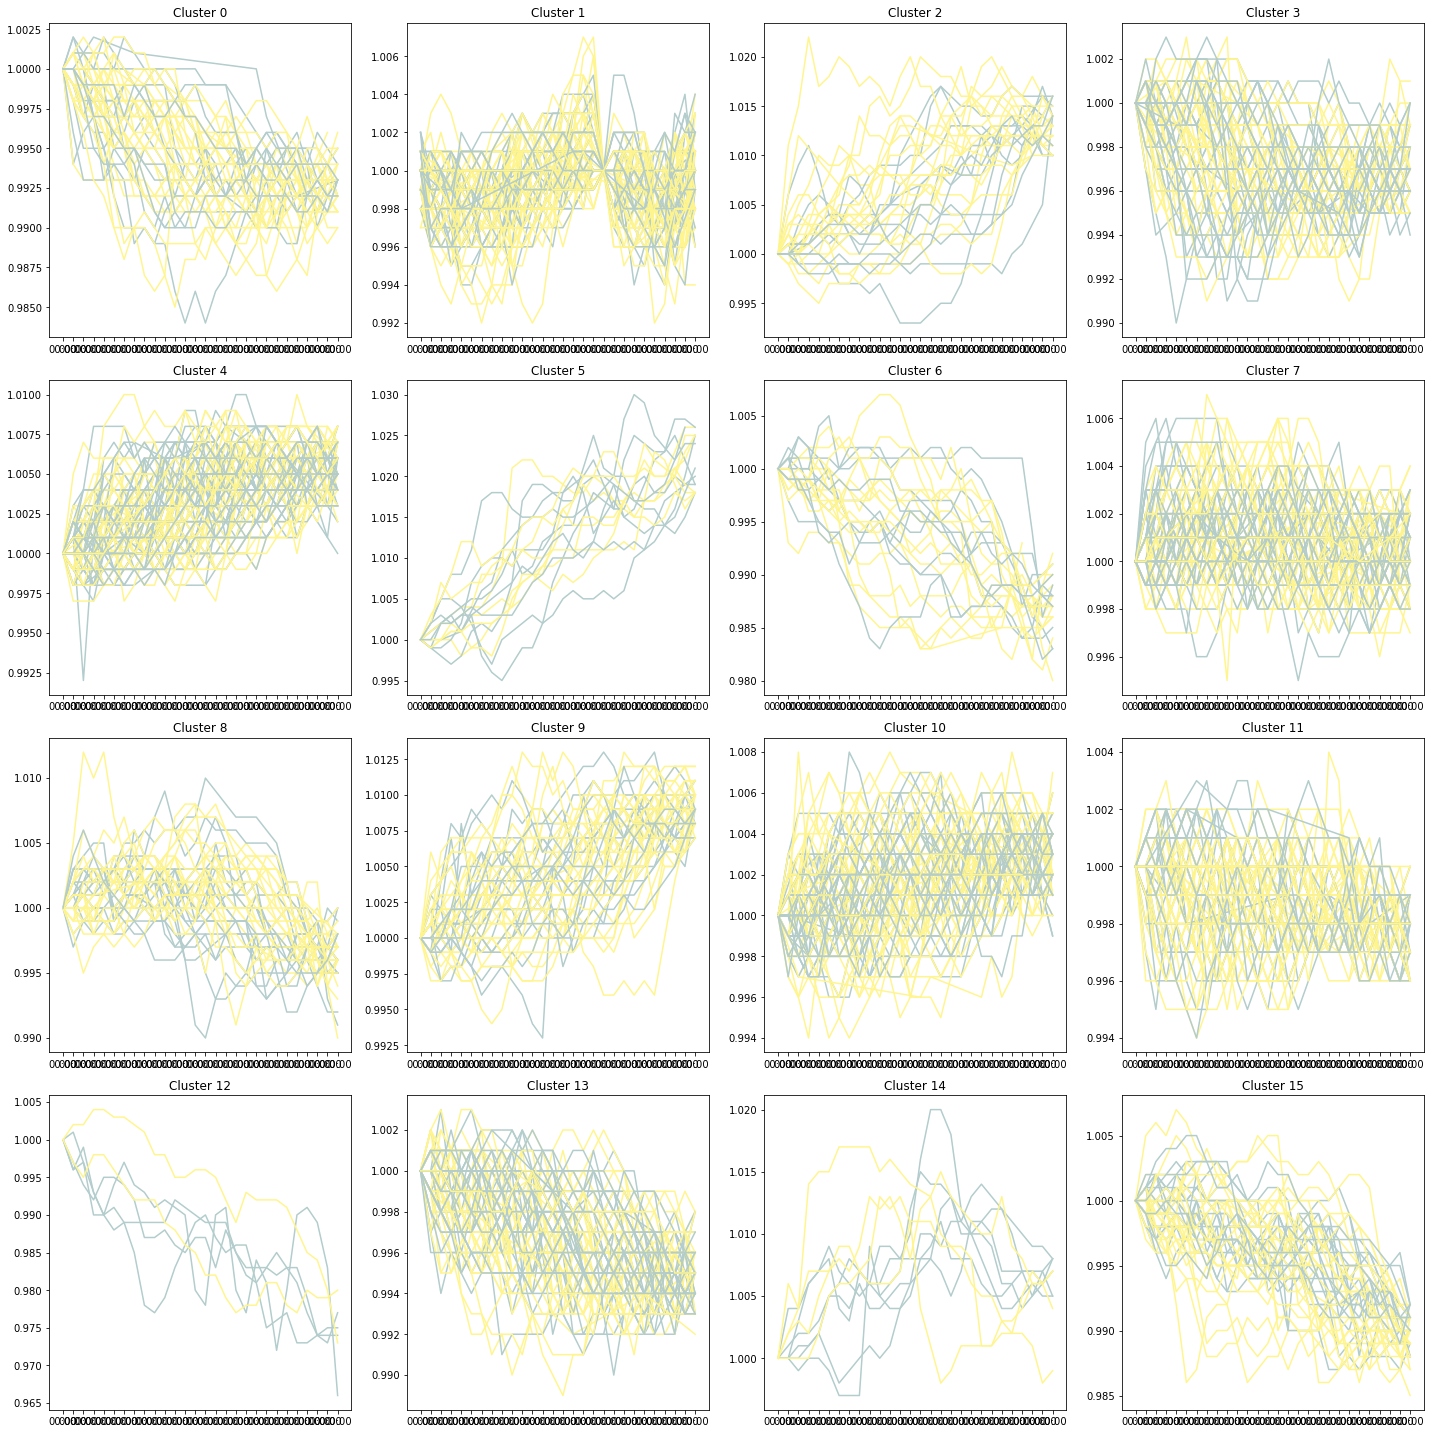

In [35]:
show_clustering(16,y_pred,res,"sdf")